## Separar los datos recolectados por bloques

In [ ]:
# Importar librerías necesarias
!pip install pandas openpyxl

import pandas as pd

# Cargar los datos desde el archivo original
input_file = "ReporteResultadosActualizado.xlsx"
df_pc = pd.read_excel(input_file, sheet_name="ReportePC")
df_laptop = pd.read_excel(input_file, sheet_name="ReporteLaptop")

# Renombrar columnas para estandarizar
for df in [df_pc, df_laptop]:
    df.rename(columns={"ver": "version", "typeData": "type", "ISA": "ISA_type"}, inplace=True)

# Función para procesar bloques y calcular métricas
def calcular_metricas_por_bloque(df, output_file):
    df['block'] = df.apply(
        lambda row: f"{row['version']} {row['type']} {row['ISA_type']} {row['n']}", axis=1
    )

    # Agrupar por bloques y calcular métricas
    resumen = df.groupby('block').agg(
        version=('version', 'first'),  # Nuevo campo agregado
        typedata=('type', 'first'),   # Nuevo campo agregado
        ISA_type=('ISA_type', 'first'),  # Nuevo campo agregado
        n=('n', 'first'),  # Valor único de 'n' para cada bloque
        Nsample=('#sample', 'count'),  # Número de elementos en el bloque
        media_normalized=('Normalized(ns)', 'mean'),  # Media
        varianza_normalized=('Normalized(ns)', 'var'),  # Varianza muestral
        desviacion_estandar=('Normalized(ns)', 'std'),  # Desviación estándar
        media_time=('time(s)', 'mean')  # Media del tiempo
    ).reset_index()

    # Guardar el resumen en un archivo Excel
    resumen.to_excel(output_file, index=False)
    print(f"Resumen guardado en: {output_file}")

# Procesar y generar los archivos de salida para cada hoja
calcular_metricas_por_bloque(df_pc, "ResumenPC_Bloques.xlsx")
calcular_metricas_por_bloque(df_laptop, "ResumenLaptop_Bloques.xlsx")

Resumen guardado en: ResumenPC_Bloques.xlsx
Resumen guardado en: ResumenLaptop_Bloques.xlsx


## Diagramas de Cajas para Revisar posibles valores atipicos

Generando diagramas de cajas con valores atípicos significativos para PC...
Generando diagramas de cajas con valores atípicos significativos para Laptop...


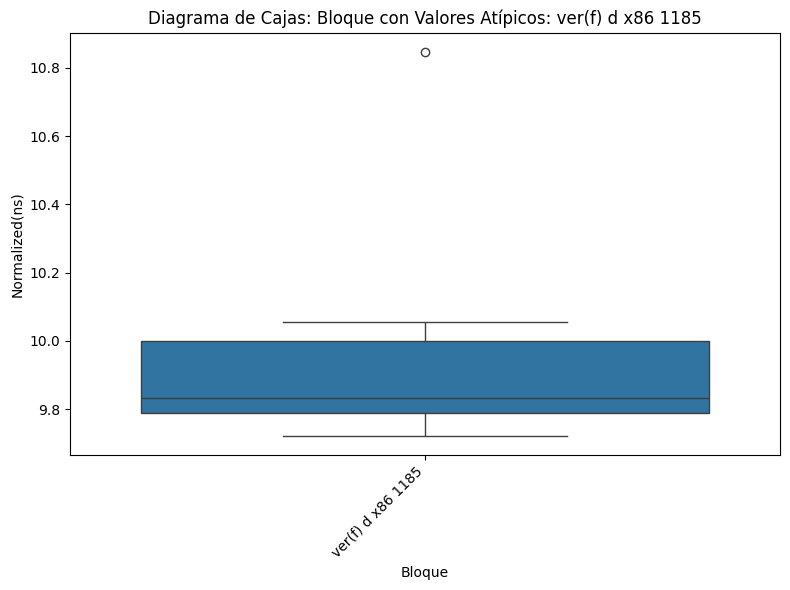

In [ ]:
!pip install pandas openpyxl seaborn matplotlib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo original
input_file = "ReporteResultados.xlsx"
df_pc = pd.read_excel(input_file, sheet_name="ReportePC")
df_laptop = pd.read_excel(input_file, sheet_name="ReporteLaptop")

# Renombrar columnas para estandarizar
for df in [df_pc, df_laptop]:
    df.rename(columns={"ver": "version", "typeData": "type", "ISA": "ISA_type"}, inplace=True)

# Función para identificar bloques con valores atípicos y mostrar gráficos
def mostrar_boxplots_valores_atipicos(df):
    df['block'] = df.apply(
        lambda row: f"{row['version']} {row['type']} {row['ISA_type']} {row['n']}", axis=1
    )

    # Obtener bloques únicos
    unique_blocks = df['block'].unique()

    # Iterar sobre cada bloque
    for block in unique_blocks:
        # Filtrar datos del bloque actual
        data_bloque = df[df['block'] == block]

        # Calcular los límites del diagrama de caja (IQR)
        Q1 = data_bloque['Normalized(ns)'].quantile(0.25)
        Q3 = data_bloque['Normalized(ns)'].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Identificar valores atípicos por debajo y por encima de los límites
        valores_por_debajo = data_bloque[data_bloque['Normalized(ns)'] < limite_inferior]
        valores_por_encima = data_bloque[data_bloque['Normalized(ns)'] > limite_superior]

        # Redondear los valores atípicos detectados
        max_valor_atipico_redondeado = (
            valores_por_encima['Normalized(ns)'].max() if not valores_por_encima.empty else None
        )
        min_valor_atipico_redondeado = (
            valores_por_debajo['Normalized(ns)'].min() if not valores_por_debajo.empty else None
        )

        # Calcular diferencias y verificar las condiciones
        mostrar_grafico = False
        if max_valor_atipico_redondeado is not None:
            diferencia_max = round(max_valor_atipico_redondeado) - Q3
            if diferencia_max > 1:
                mostrar_grafico = True

        if min_valor_atipico_redondeado is not None:
            diferencia_min = Q1 - round(min_valor_atipico_redondeado)
            if diferencia_min > 1:
                mostrar_grafico = True

        # Si cumple las condiciones, mostrar el gráfico
        if mostrar_grafico:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x='block', y='Normalized(ns)', data=data_bloque)
            plt.title(f'Diagrama de Cajas: Bloque con Valores Atípicos: {block}')
            plt.xlabel('Bloque')
            plt.ylabel('Normalized(ns)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

# Mostrar diagramas de cajas para bloques con valores atípicos según la nueva lógica
print("Generando diagramas de cajas con valores atípicos significativos para PC...")
mostrar_boxplots_valores_atipicos(df_pc)

print("Generando diagramas de cajas con valores atípicos significativos para Laptop...")
mostrar_boxplots_valores_atipicos(df_laptop)
